In [1]:
import os
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pickle

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, Lasso, Ridge
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)

import warnings
warnings.filterwarnings('ignore')

/Users/andreacsorcinelli/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load Data & Final Cleaning

In [2]:
directory = '/Users/andreacsorcinelli/Documents/01_Personal/02_Job Stuff/01_Metis/02_Metis_GH/03_Projects/02_Luther/03_Regression/'

In [3]:
df = pd.read_csv('agg_data_processed_170718.csv', encoding = 'ISO-8859-1')

In [4]:
df.head()

,Num_Years,Name,Season,Squad,Country,Competition,LgRank,Age,Games,Game_Starts,...,Prev_Game_Starts,Prev_Game_Subs,Prev_Min,Prev_Min_p_Game,Prev_Goals,Prev_Assists,Prev_Fouls,Prev_Yellow_Cards,Prev_Red_Cards,Prev_Shots_Target
0,1.0,Aaron-Hunt,2004-2005,Werder Bremen,de GER,1. Bundesliga,3rd,17.0,10.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,Aaron-Hunt,2005-2006,Werder Bremen,de GER,1. Bundesliga,2nd,18.0,7.0,1.0,...,2.0,8.0,338.0,34.0,1.0,2.0,NaN,0.0,0.0,5.0
2,3.0,Aaron-Hunt,2006-2007,Werder Bremen,de GER,1. Bundesliga,3rd,19.0,28.0,18.0,...,1.0,6.0,232.0,33.0,0.0,0.0,NaN,0.0,0.0,4.0
3,4.0,Aaron-Hunt,2007-2008,Werder Bremen,de GER,1. Bundesliga,2nd,20.0,14.0,6.0,...,18.0,10.0,1660.0,59.0,9.0,4.0,40.0,6.0,0.0,13.0
4,5.0,Aaron-Hunt,2008-2009,Werder Bremen,de GER,1. Bundesliga,10th,21.0,18.0,13.0,...,6.0,8.0,875.0,63.0,1.0,3.0,21.0,5.0,0.0,3.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 37 columns):
Num_Years             2942 non-null float64
Name                  2942 non-null object
Season                2942 non-null object
Squad                 2942 non-null object
Country               2942 non-null object
Competition           2942 non-null object
LgRank                2942 non-null object
Age                   2942 non-null float64
Games                 2942 non-null float64
Game_Starts           2942 non-null float64
Game_Subs             2942 non-null float64
Min                   2942 non-null float64
Min_p_Game            2942 non-null float64
Goals                 2942 non-null float64
Assists               2902 non-null float64
Fouls                 2458 non-null float64
Yellow_Cards          2942 non-null float64
Red_Cards             2942 non-null float64
Shots_Target          2896 non-null float64
Goals_p_90            2942 non-null float64
Goals_Assists_p_90 

In [6]:
# drop a row that has any occurence of a null value
df = df.dropna(how = 'any')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2241 entries, 3 to 2941
Data columns (total 37 columns):
Num_Years             2241 non-null float64
Name                  2241 non-null object
Season                2241 non-null object
Squad                 2241 non-null object
Country               2241 non-null object
Competition           2241 non-null object
LgRank                2241 non-null object
Age                   2241 non-null float64
Games                 2241 non-null float64
Game_Starts           2241 non-null float64
Game_Subs             2241 non-null float64
Min                   2241 non-null float64
Min_p_Game            2241 non-null float64
Goals                 2241 non-null float64
Assists               2241 non-null float64
Fouls                 2241 non-null float64
Yellow_Cards          2241 non-null float64
Red_Cards             2241 non-null float64
Shots_Target          2241 non-null float64
Goals_p_90            2241 non-null float64
Goals_Assists_p_90 

In [8]:
#Defining DF
#dropping features & setting x, y
#10 features: y is Game
X, y = df.drop(['Age','Games','Goals','Assists','Min','Game_Starts','Shots_Target','Min_p_Game','Fouls',\
                'Red_Cards','LgRank','Goals_p_90', 'Goals_Assists_p_90',\
                'Shots_Target_p_90', 'Fouls_p_90', 'Cards_p_90','Squad','Country',\
                'Competition', 'Name', 'Num_Years','Yellow_Cards','Prev_Yellow_Cards',\
                'Prev_Shots_Target', 'Prev_Min_p_Game', 'Prev_Game_Starts','Prev_Game_Subs',\
                'Season','Game_Subs'],axis=1), df['Games']

### Build a Hold Out Set to Test Different Models Min

In [9]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
X,y

(     Prev_LgRank  Prev_Age  Prev_Games  Prev_Min  Prev_Goals  Prev_Assists  \
 3            3rd      19.0        28.0    1660.0         9.0           4.0   
 4            2nd      20.0        14.0     875.0         1.0           3.0   
 5           10th      21.0        18.0    1114.0         2.0           3.0   
 6            3rd      22.0        32.0    2312.0         9.0           4.0   
 7           13th      23.0        29.0    1872.0         3.0           3.0   
 8            9th      24.0        18.0    1597.0         3.0           3.0   
 9           14th      25.0        28.0    2340.0        11.0           4.0   
 10          12th      26.0        31.0    2666.0         7.0           7.0   
 11           2nd      27.0        15.0     429.0         2.0           0.0   
 12           8th      28.0         2.0      81.0         0.0           0.0   
 13          10th      28.0        21.0    1652.0         1.0           2.0   
 14          14th      29.0        22.0    1302.0   

In [11]:
df = pd.DataFrame(X)
df.columns = ["X" + str(col) for col in df.columns]
df["target"] = y

In [12]:
df.shape

(2241, 9)

In [13]:
df.columns

Index(['XPrev_LgRank', 'XPrev_Age', 'XPrev_Games', 'XPrev_Min', 'XPrev_Goals',
       'XPrev_Assists', 'XPrev_Fouls', 'XPrev_Red_Cards', 'target'],
      dtype='object')

### EDA Games

In [14]:
#correlations
df.corr()

,XPrev_Age,XPrev_Games,XPrev_Min,XPrev_Goals,XPrev_Assists,XPrev_Fouls,XPrev_Red_Cards,target
XPrev_Age,1.000000,0.002318,0.024909,-0.090147,-0.088826,-0.153679,-0.030090,-0.171983
XPrev_Games,0.002318,1.000000,0.920993,0.291846,0.312853,0.457221,0.102006,0.349450
XPrev_Min,0.024909,0.920993,1.000000,0.243986,0.268719,0.421521,0.117597,0.353784
XPrev_Goals,-0.090147,0.291846,0.243986,1.000000,0.537613,0.293664,0.012042,0.097824
XPrev_Assists,-0.088826,0.312853,0.268719,0.537613,1.000000,0.285411,0.032485,0.134295
XPrev_Fouls,-0.153679,0.457221,0.421521,0.293664,0.285411,1.000000,0.209443,0.163076
XPrev_Red_Cards,-0.030090,0.102006,0.117597,0.012042,0.032485,0.209443,1.000000,0.067736
target,-0.171983,0.349450,0.353784,0.097824,0.134295,0.163076,0.067736,1.000000


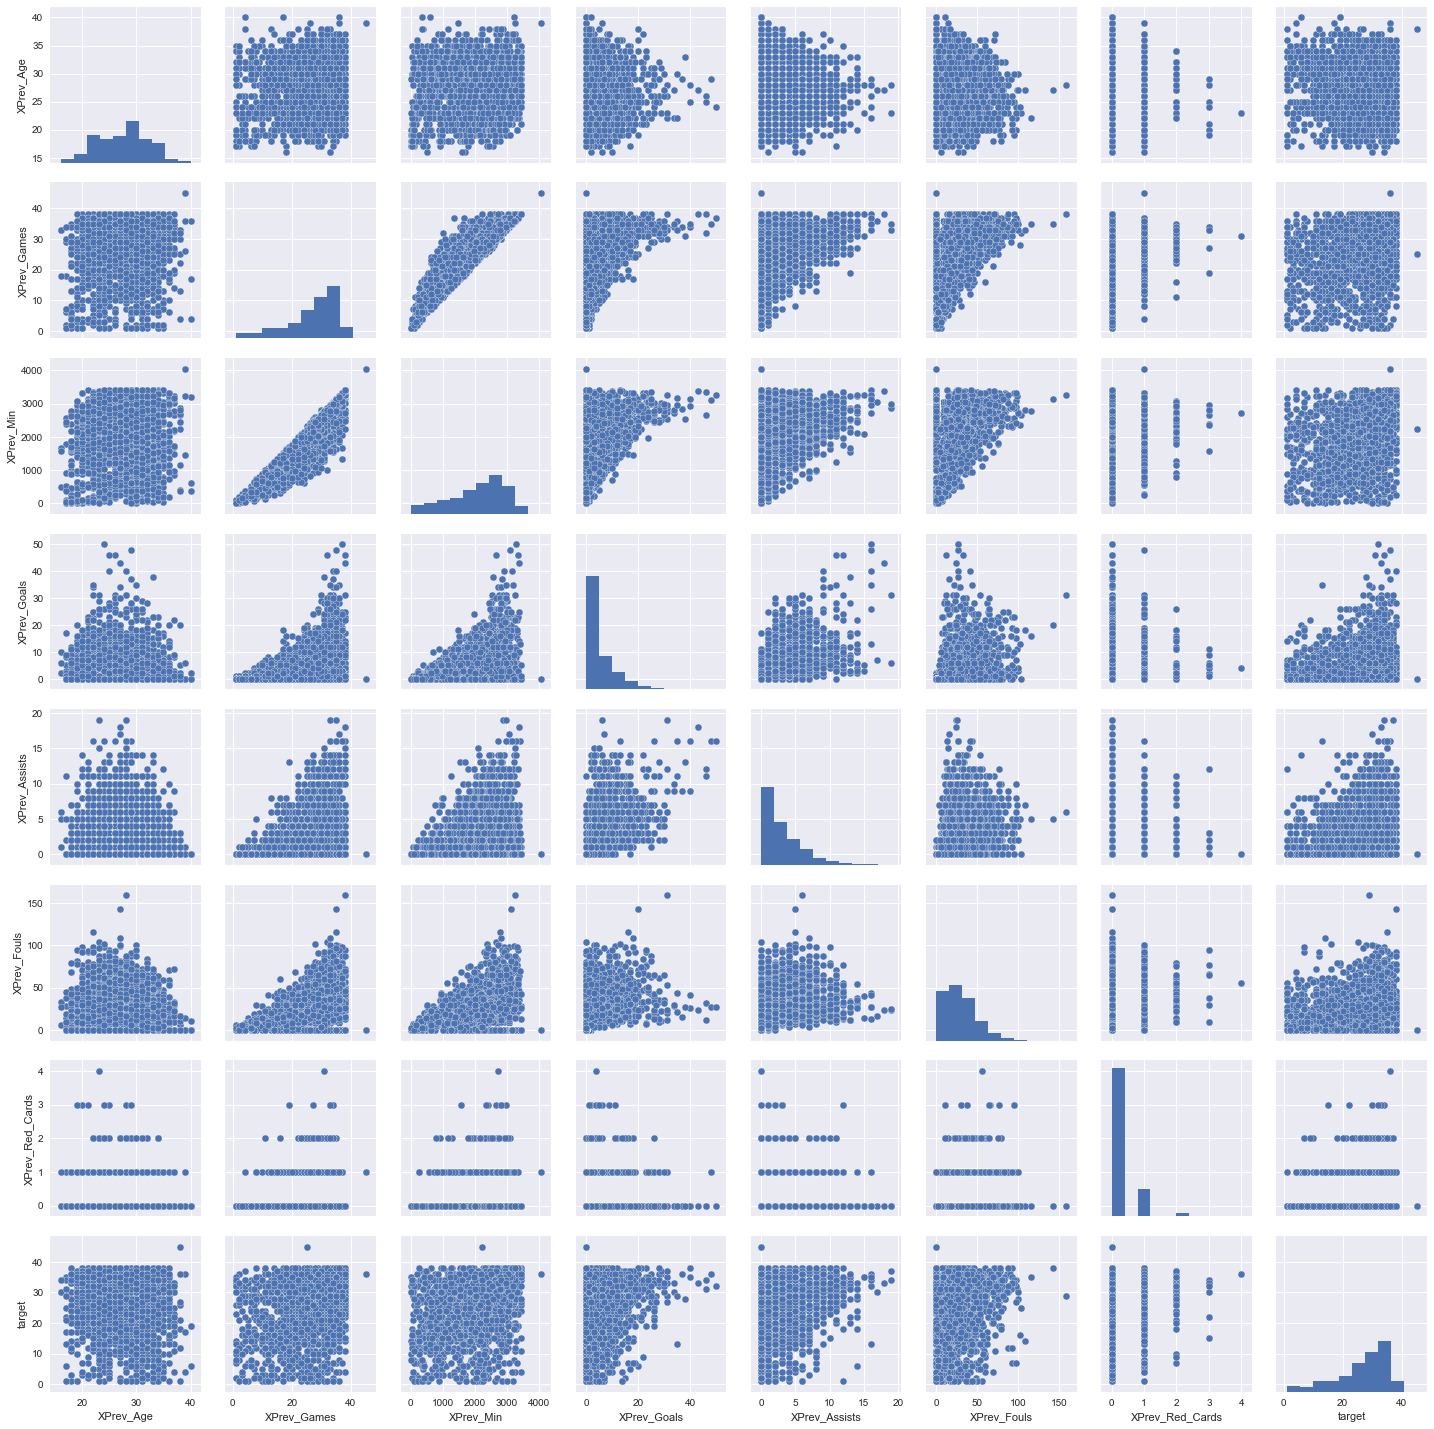

In [15]:
#sns.pairplot(pd.DataFrame(np.nan_to_num(df)))
sns.pairplot(df)

In [16]:
df.dtypes

XPrev_LgRank        object
XPrev_Age          float64
XPrev_Games        float64
XPrev_Min          float64
XPrev_Goals        float64
XPrev_Assists      float64
XPrev_Fouls        float64
XPrev_Red_Cards    float64
target             float64
dtype: object

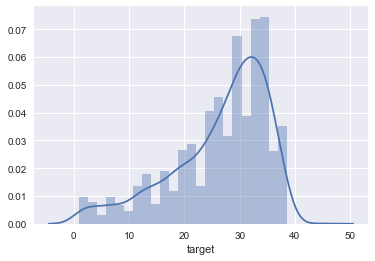

In [17]:
#distribution of the target variable 
sns.distplot(df['target'])

### Baseline: Linear Regression

In [18]:
#baseline model & OLS regression summary stats
X=df.loc[:,['XPrev_Min']]

y=df['target']


model = sm.OLS(y,sm.add_constant(X))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     320.3
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           4.61e-67
Time:                        09:09:07   Log-Likelihood:                -7884.2
No. Observations:                2241   AIC:                         1.577e+04
Df Residuals:                    2239   BIC:                         1.578e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.9308      0.454     41.702      0.000      18.041      19.821
XPrev_Min      0.0036      0.000     17.898      0.000       0.003       0.004
==============================================================================
Omnibus:                      278.644   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              391.173
Skew:                          -0.958   Prob(JB):                     1.14e-85
Kurtosis:                       3.722   Cond. No.                     5.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
#baseline model & OLS regression summary stats
X=df.loc[:,['XPrev_Min', 'XPrev_Games']]

y=df['target']


model = sm.OLS(y,sm.add_constant(X))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     165.5
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           9.34e-68
Time:                        09:09:08   Log-Likelihood:                -7879.5
No. Observations:                2241   AIC:                         1.577e+04
Df Residuals:                    2238   BIC:                         1.578e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          17.7882      0.586     30.346      0.000      16.639      18.938
XPrev_Min       0.0022      0.001      4.156      0.000       0.001       0.003
XPrev_Games     0.1567      0.051      3.073      0.002       0.057       0.257
==============================================================================
Omnibus:                      281.723   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.937
Skew:                          -0.960   Prob(JB):                     3.88e-87
Kurtosis:                       3.759   Cond. No.                     7.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
#baseline model & OLS regression summary stats
X=df.loc[:,['XPrev_Min','XPrev_Games', 'XPrev_Age']]

y=df['target']


model = sm.OLS(y,sm.add_constant(X))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     142.5
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           1.61e-84
Time:                        09:09:09   Log-Likelihood:                -7838.1
No. Observations:                2241   AIC:                         1.568e+04
Df Residuals:                    2237   BIC:                         1.571e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          27.3226      1.187     23.015      0.000      24.995      29.651
XPrev_Min       0.0024      0.001      4.762      0.000       0.001       0.003
XPrev_Games     0.1323      0.050      2.639      0.008       0.034       0.231
XPrev_Age      -0.3454      0.038     -9.183      0.000      -0.419      -0.272
==============================================================================
Omnibus:                      277.698   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              394.173
Skew:                          -0.938   Prob(JB):                     2.55e-86
Kurtosis:                       3.838   Cond. No.                     1.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
#baseline model & OLS regression summary stats
X=df.loc[:,['XPrev_Min','XPrev_Games','XPrev_Age','XPrev_Fouls']]

y=df['target']


model = sm.OLS(y,sm.add_constant(X))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     107.5
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           7.49e-84
Time:                        09:09:10   Log-Likelihood:                -7837.0
No. Observations:                2241   AIC:                         1.568e+04
Df Residuals:                    2236   BIC:                         1.571e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          27.5843      1.201     22.972      0.000      25.230      29.939
XPrev_Min       0.0024      0.001      4.780      0.000       0.001       0.003
XPrev_Games     0.1462      0.051      2.863      0.004       0.046       0.246
XPrev_Age      -0.3549      0.038     -9.295      0.000      -0.430      -0.280
XPrev_Fouls    -0.0133      0.009     -1.437      0.151      -0.032       0.005
==============================================================================
Omnibus:                      281.746   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              402.246
Skew:                          -0.945   Prob(JB):                     4.50e-88
Kurtosis:                       3.856   Cond. No.                     1.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
#baseline model & OLS regression summary stats
X=df.loc[:,['XPrev_Min','XPrev_Games','XPrev_Age','XPrev_Fouls', 'XPrev_Assists']]

y=df['target']


model = sm.OLS(y,sm.add_constant(X))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     86.17
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           5.14e-83
Time:                        09:09:11   Log-Likelihood:                -7836.5
No. Observations:                2241   AIC:                         1.569e+04
Df Residuals:                    2235   BIC:                         1.572e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            27.5379      1.202     22.916      0.000      25.181      29.894
XPrev_Min         0.0025      0.001      4.822      0.000       0.001       0.003
XPrev_Games       0.1391      0.052      2.698      0.007       0.038       0.240
XPrev_Age        -0.3525      0.038     -9.213      0.000      -0.428      -0.277
XPrev_Fouls      -0.0148      0.009     -1.572      0.116      -0.033       0.004
XPrev_Assists     0.0564      0.057      0.980      0.327      -0.056       0.169
==============================================================================
Omnibus:                      279.094   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.194
Skew:                          -0.940   Prob(JB):                     5.63e-87
Kurtosis:                       3.849   Cond. No.                     1.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
#baseline model & OLS regression summary stats
X=df.loc[:,['XPrev_Min','XPrev_Games','XPrev_Age','XPrev_Fouls', 'XPrev_Assists','XPrev_Goals']]

y=df['target']


model = sm.OLS(y,sm.add_constant(X))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     72.03
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           2.65e-82
Time:                        09:09:12   Log-Likelihood:                -7835.9
No. Observations:                2241   AIC:                         1.569e+04
Df Residuals:                    2234   BIC:                         1.573e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            27.5476      1.202     22.925      0.000      25.191      29.904
XPrev_Min         0.0024      0.001      4.765      0.000       0.001       0.003
XPrev_Games       0.1441      0.052      2.784      0.005       0.043       0.246
XPrev_Age        -0.3540      0.038     -9.247      0.000      -0.429      -0.279
XPrev_Fouls      -0.0135      0.009     -1.429      0.153      -0.032       0.005
XPrev_Assists     0.0912      0.065      1.400      0.162      -0.037       0.219
XPrev_Goals      -0.0361      0.032     -1.136      0.256      -0.098       0.026
==============================================================================
Omnibus:                      277.678   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              394.595
Skew:                          -0.937   Prob(JB):                     2.06e-86
Kurtosis:                       3.847   Cond. No.                     1.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#baseline model & OLS regression summary stats
X=df.loc[:,['XPrev_Min','XPrev_Games','XPrev_Age','XPrev_Fouls', 'XPrev_Assists','XPrev_Goals','XPrev_Red_Cards']]

y=df['target']


model = sm.OLS(y,sm.add_constant(X))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     62.03
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           9.42e-82
Time:                        09:09:12   Log-Likelihood:                -7835.0
No. Observations:                2241   AIC:                         1.569e+04
Df Residuals:                    2233   BIC:                         1.573e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              27.5018      1.202     22.882      0.000      25.145      29.859
XPrev_Min           0.0024      0.001      4.678      0.000       0.001       0.003
XPrev_Games         0.1472      0.052      2.842      0.005       0.046       0.249
XPrev_Age          -0.3537      0.038     -9.242      0.000      -0.429      -0.279
XPrev_Fouls        -0.0160      0.010     -1.659      0.097      -0.035       0.003
XPrev_Assists       0.0916      0.065      1.407      0.160      -0.036       0.219
XPrev_Goals        -0.0342      0.032     -1.077      0.282      -0.097       0.028
XPrev_Red_Cards     0.5115      0.376      1.361      0.174      -0.226       1.249
==============================================================================
Omnibus:                      275.847   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              391.083
Skew:                          -0.933   Prob(JB):                     1.20e-85
Kurtosis:                       3.841   Cond. No.                     1.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
#Defining DF
#dropping features & setting x, y
#10 features: y is Game
#Defining DF
#dropping features & setting x, y
#10 features: y is Game
# X, y = df.drop(['Age','Games','Goals','Assists','Min','Game_Starts','Shots_Target','Min_p_Game','Fouls',\
#                 'Red_Cards','LgRank','Goals_p_90', 'Goals_Assists_p_90',\
#                 'Shots_Target_p_90', 'Fouls_p_90', 'Cards_p_90','Squad','Country',\
#                 'Competition', 'Name', 'Num_Years','Yellow_Cards','Prev_Yellow_Cards',\
#                 'Prev_Shots_Target', 'Prev_Min_p_Game', 'Prev_Game_Starts','Prev_Game_Subs',\
#                 'Season','Game_Subs','XPrev_Fouls','XPrev_Assists', 'XPrev_Goals', 'XPrev_Red_Cards'], axis=1), df['Games']


X, y = df.drop(['XPrev_Fouls','XPrev_Assists', 'XPrev_Goals', 'XPrev_Red_Cards','XPrev_LgRank','target'],axis=1), df['target']

### Split Training Data into Multiple Folds

In [26]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)

In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [28]:
lin_reg_est  = LinearRegression()

scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

# Build the Model
lin_reg_est.fit(X_train, y_train)

[0.11057973 0.20491353 0.14638934 0.14474891 0.1836765 ]
Linear Reg Mean Score:  0.1580616012940248


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Evaluating Model

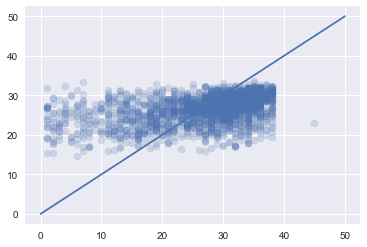

In [29]:
# Fitted vs. Actual
y_train_pred = lin_reg_est.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([0, 50], [0, 50])

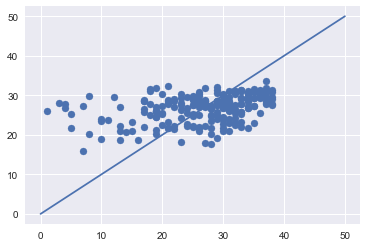

In [30]:
# Fitted vs. Actual
y_test_pred = lin_reg_est.predict(X_holdout)

plt.scatter(y_holdout, y_test_pred)
plt.plot([0, 50], [0, 50])

Text(0.5,1,'Actual vs. Residuals')

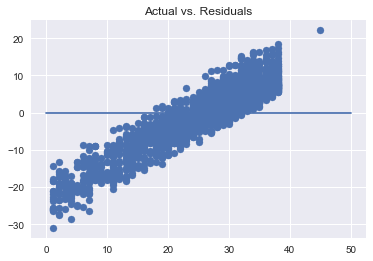

In [31]:
# Plot Residuals

lin_reg_residuals = y_train - y_train_pred

plt.scatter(y_train, lin_reg_residuals)
plt.plot([0,50], [0, 0])
plt.title("Actual vs. Residuals")

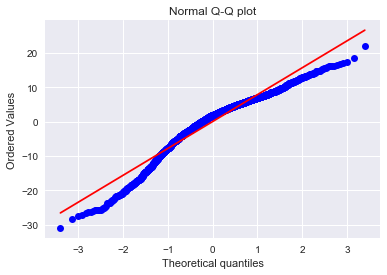

In [32]:
# plt.title("Actual vs. Residuals")

import scipy.stats as stats

stats.probplot (lin_reg_residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Plot Features to Target

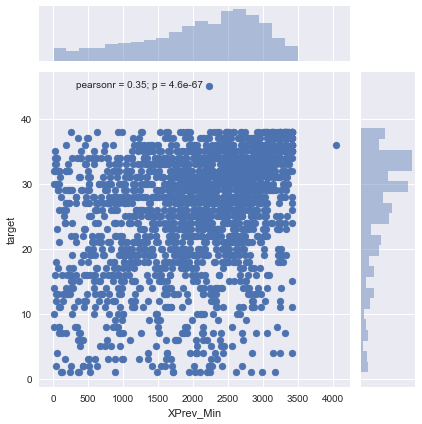

In [33]:
#sns.jointplot('target', 'XPrev_Games', data=df)
sns.jointplot('XPrev_Min', 'target', data=df)

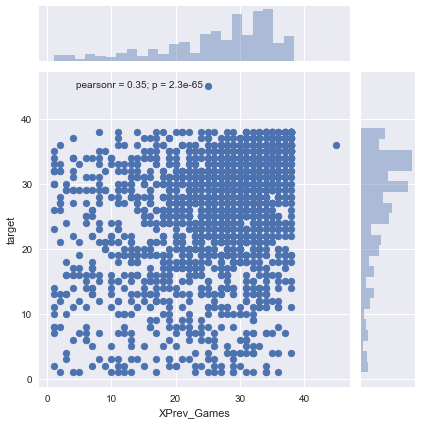

In [34]:
#sns.jointplot('target', 'XPrev_Min', data=df)
sns.jointplot('XPrev_Games', 'target', data=df)

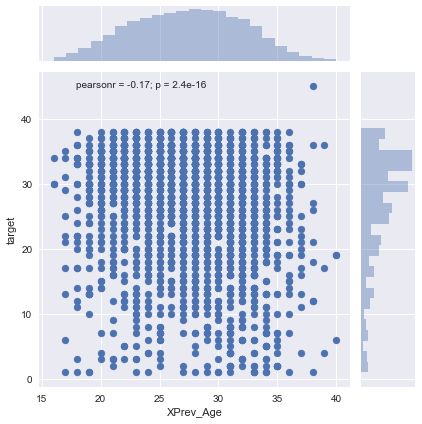

In [35]:
sns.jointplot('XPrev_Age', 'target', data=df)

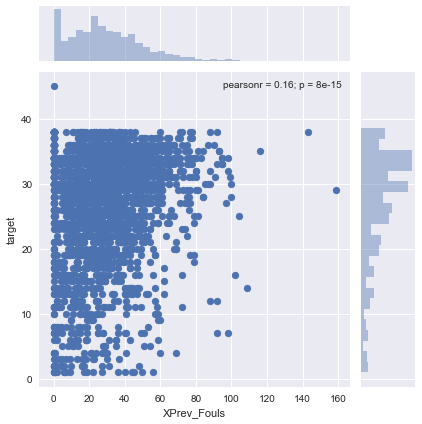

In [36]:
#sns.jointplot('target', 'XGoals', data=df)
sns.jointplot('XPrev_Fouls', 'target', data=df)

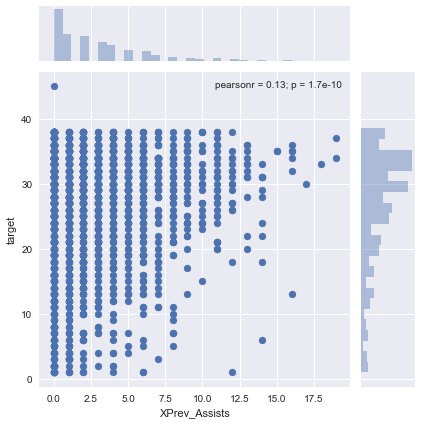

In [37]:
sns.jointplot('XPrev_Assists', 'target', data=df)

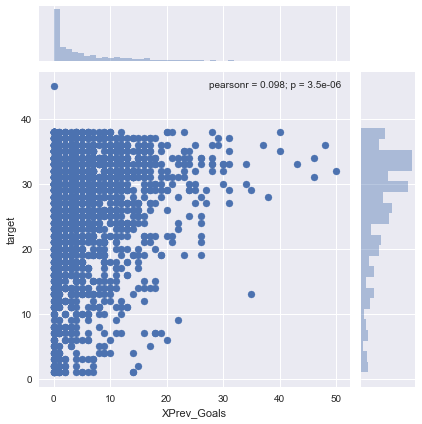

In [38]:
sns.jointplot('XPrev_Goals', 'target', data=df)

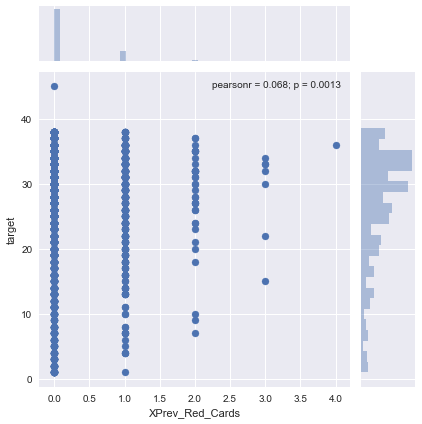

In [39]:
sns.jointplot('XPrev_Red_Cards', 'target', data=df)

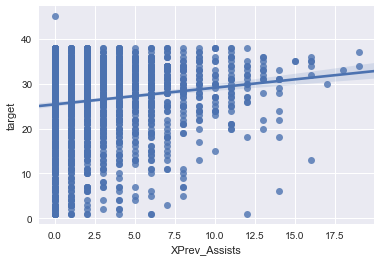

In [40]:
sns.regplot(x="XPrev_Assists", y="target", data=df)

# plt.xlim(0, 20)
# plt.ylim(0, 50)

### Clearly I am not capturing something; let's try adding polynimials 

In [41]:
def add_square_terms(df):    
    
    df_poly = df.copy()
    
    for c in df.columns:
        df_poly[c + '**2'] = df[c]**2
        
    return df_poly

In [42]:
from sklearn.metrics import mean_squared_error

def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted))

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=3)

lm = LinearRegression()
lm.fit(X_train, y_train)
print('OLS regression score val R^2: %.3f' % lm.score(X_val, y_val))
print('OLS regression score val RMSE: %.3f \n' % RMSE(lm.predict(X_val), y_val))

lm.fit(add_square_terms(X_train), y_train)
print('Degree 2 polynomial regression val R^2: %.3f' 
      % lm.score(add_square_terms(X_val), y_val))
print('Degree 2 polynomial regression score val RMSE: %.3f' 
      % RMSE(lm.predict(add_square_terms(X_val)), y_val))

OLS regression score val R^2: 0.165
OLS regression score val RMSE: 8.110 

Degree 2 polynomial regression val R^2: 0.179
Degree 2 polynomial regression score val RMSE: 8.039


### Plotting Residuals with poly term

Text(0,0.5,'Residual')

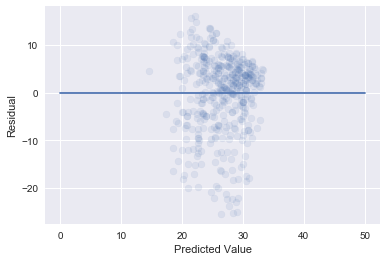

In [44]:
y_pred = lm.predict(add_square_terms(X_val))

plt.scatter(y_pred,y_val-y_pred,alpha=.1)
plt.plot(np.linspace(0,50,1000),np.linspace(0,0,1000))
plt.xlabel('Predicted Value')
plt.ylabel('Residual')

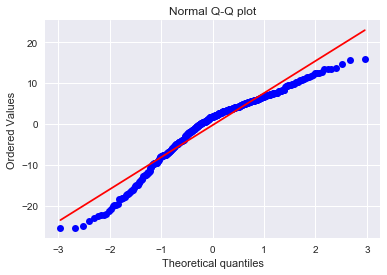

In [45]:
# lin_reg_residuals = y_train - y_train_pred

poly_reg_residuals = y_val-y_pred

stats.probplot (poly_reg_residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Evaluating Models using Holdout Set

In [46]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = lin_reg_est.predict(X_holdout)
print("Linear Regression:", r2_score(y_holdout, y_pred))

Linear Regression: 0.1259018284733482


In [47]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

lm_poly = LinearRegression()
lm_poly.fit(poly.fit_transform(X_train), y_train)
y_pred = lm_poly.predict(poly.transform(X_holdout))
print("Polynomial Regression:", r2_score(y_holdout, y_pred))

Polynomial Regression: 0.12682874237945596


### More Correlations Just In Case 

In [48]:
directory = '/Users/andreacsorcinelli/Documents/01_Personal/02_Job Stuff/01_Metis/02_Metis_GH/03_Projects/02_Luther/03_Regression/'

In [49]:
df = pd.read_csv('agg_data_processed_170718.csv', encoding = 'ISO-8859-1')

In [50]:
# drop a row that has any occurence of a null value
df = df.dropna(how = 'any')

In [52]:
#Defining DF
#dropping features & setting x, y
#10 features: y is Game
X, y = df.drop(['Age','Games','Goals','Assists','Min','Game_Starts','Shots_Target','Min_p_Game','Fouls',\
                'Red_Cards','LgRank','Goals_p_90', 'Goals_Assists_p_90','Shots_Target_p_90', 'Fouls_p_90',\
                'Cards_p_90','Squad','Country','Competition', 'Name', 'Num_Years','Yellow_Cards','Prev_Min_p_Game',\
                'Season','Game_Subs'],axis=1), df['Games']

In [53]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)

In [54]:
X, y

(     Prev_LgRank  Prev_Age  Prev_Games  Prev_Game_Starts  Prev_Game_Subs  \
 3            3rd      19.0        28.0              18.0            10.0   
 4            2nd      20.0        14.0               6.0             8.0   
 5           10th      21.0        18.0              13.0             5.0   
 6            3rd      22.0        32.0              26.0             6.0   
 7           13th      23.0        29.0              21.0             8.0   
 8            9th      24.0        18.0              18.0             0.0   
 9           14th      25.0        28.0              26.0             2.0   
 10          12th      26.0        31.0              31.0             0.0   
 11           2nd      27.0        15.0               3.0            12.0   
 12           8th      28.0         2.0               1.0             1.0   
 13          10th      28.0        21.0              19.0             2.0   
 14          14th      29.0        22.0              14.0             8.0   

In [55]:
df = pd.DataFrame(X)
df.columns = ["X" + str(col) for col in df.columns]
df["target"] = y

In [56]:
df.corr()

,XPrev_Age,XPrev_Games,XPrev_Game_Starts,XPrev_Game_Subs,XPrev_Min,XPrev_Goals,XPrev_Assists,XPrev_Fouls,XPrev_Yellow_Cards,XPrev_Red_Cards,XPrev_Shots_Target,target
XPrev_Age,1.000000,0.002318,0.027267,-0.059319,0.024909,-0.090147,-0.088826,-0.153679,-0.038432,-0.030090,-0.142137,-0.171983
XPrev_Games,0.002318,1.000000,0.905566,-0.082679,0.920993,0.291846,0.312853,0.457221,0.375537,0.102006,0.339076,0.349450
XPrev_Game_Starts,0.027267,0.905566,1.000000,-0.497625,0.992549,0.250206,0.277532,0.434394,0.396162,0.127324,0.287983,0.349243
XPrev_Game_Subs,-0.059319,-0.082679,-0.497625,1.000000,-0.448577,0.008948,-0.012295,-0.085611,-0.162817,-0.090542,0.016772,-0.105933
XPrev_Min,0.024909,0.920993,0.992549,-0.448577,1.000000,0.243986,0.268719,0.421521,0.386340,0.117597,0.280349,0.353784
XPrev_Goals,-0.090147,0.291846,0.250206,0.008948,0.243986,1.000000,0.537613,0.293664,0.074178,0.012042,0.931668,0.097824
XPrev_Assists,-0.088826,0.312853,0.277532,-0.012295,0.268719,0.537613,1.000000,0.285411,0.167720,0.032485,0.608138,0.134295
XPrev_Fouls,-0.153679,0.457221,0.434394,-0.085611,0.421521,0.293664,0.285411,1.000000,0.627482,0.209443,0.357543,0.163076
XPrev_Yellow_Cards,-0.038432,0.375537,0.396162,-0.162817,0.386340,0.074178,0.167720,0.627482,1.000000,0.294542,0.120606,0.139990
XPrev_Red_Cards,-0.030090,0.102006,0.127324,-0.090542,0.117597,0.012042,0.032485,0.209443,0.294542,1.000000,0.035730,0.067736


In [57]:
# adding game starts in just in case
# doesn't add anything to the model
X=df.loc[:,['XPrev_Min','XPrev_Games', 'XPrev_Age','XPrev_Game_Starts']]

y=df['target']


model = sm.OLS(y,sm.add_constant(X))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     106.9
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           2.07e-83
Time:                        09:15:51   Log-Likelihood:                -7838.1
No. Observations:                2241   AIC:                         1.569e+04
Df Residuals:                    2236   BIC:                         1.571e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                27.3166      1.188     22.990      0.000      24.987      29.647
XPrev_Min             0.0027      0.002      1.482      0.138      -0.001       0.006
XPrev_Games           0.1311      0.051      2.570      0.010       0.031       0.231
XPrev_Age            -0.3453      0.038     -9.179      0.000      -0.419      -0.272
XPrev_Game_Starts    -0.0199      0.142     -0.141      0.888      -0.298       0.258
==============================================================================
Omnibus:                      277.974   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              394.728
Skew:                          -0.938   Prob(JB):                     1.93e-86
Kurtosis:                       3.839   Cond. No.                     1.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""